<a href="https://colab.research.google.com/github/alexparizeau/IEORE4524-P033B/blob/main/NER_Final_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment setup

In [ ]:
!pip install torch

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 8.1 MB/s 
     |████████████████████████████████| 880 kB 58.1 MB/s 
     |████████████████████████████████| 6.6 MB 34.2 MB/s 
     |████████████████████████████████| 596 kB 54.1 MB/s 
     |████████████████████████████████| 77 kB 5.7 MB/s 
     |████████████████████████████████| 96 kB 6.2 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.50-py3-none-any.whl size=895166 sha256=7397877ca8beade71517f76cae6f47c9fa371fee8dfb301331a40bce2ff1fd86
  Stored in directory: /root/.cache/pip/wheels/d9/72/54/519f0d5143cc6c73fa3297509123c86fc8586a7fdea8d25311
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into a

In [ ]:
!pip install transformers seqeval[gpu]

     |████████████████████████████████| 43 kB 1.6 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=614174b4590d6a2cce1eb973709109ec0eedbeefe559a261f38f568b5360d98e
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
from transformers import pipeline
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification
from transformers import AutoTokenizer, AutoModelForTokenClassification
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 1. Supervised NER models

## On Conll Dataset (Standard English)

### Data Loading

In [ ]:
conll_train = drive.CreateFile({'id':'14dvjq020icKk21X0H2m2VLYIhHfe3ga0'}) 
conll_train.GetContentFile('Conll_train.txt')
conll_valid = drive.CreateFile({'id':'1MSJiPNgWKPuK2wOTeNBOnGqZR-Qvq6VV'}) 
conll_valid.GetContentFile('Conll_valid.txt')
conll_test = drive.CreateFile({'id':'1RYuoceeUyExeZdGJvPsSVzCBqDAbUUdp'}) 
conll_test.GetContentFile('Conll_test.txt')

### Data preprocessing

In [ ]:
def get_raw_df(txt_list):
  i = 0
  all_list = [sentence.strip().split() for sentence in txt_list]
  for l in all_list:
    if l == []:
      i += 1
    else:
      l.append(f'sentence {i}')
  all_list = [x for x in all_list if x and x[4] != "sentence 0"]
  df = pd.DataFrame(all_list, columns=["id", "pos_tags","chunk_tags","ner_tags", "sentence number"])
  return df

def get_preprocessed_df(txt_list, tag_name):
  raw_df = get_raw_df(txt_list)
  """tag_name is a string representing tag name from "pos_tags","chunk_tags","ner_tags" """
  raw_df["sentence"] = raw_df[["sentence number", "id", "ner_tags"]].groupby(["sentence number"])["id"].transform(lambda x: " ".join(x))
  raw_df["labels"] = raw_df[["sentence number", "id", "ner_tags"]].groupby(["sentence number"])[tag_name].transform(lambda x: " ".join(x))
  return raw_df


In [ ]:
with open("Conll_train.txt") as f:
  train = f.readlines()
df_train_raw = get_preprocessed_df(train, "ner_tags")

with open("Conll_valid.txt") as f:
  valid = f.readlines()
df_valid_raw = get_preprocessed_df(valid, "ner_tags")

with open("Conll_test.txt") as f:
  test = f.readlines()
df_test_raw = get_preprocessed_df(test, "ner_tags")

In [ ]:
print(f"Length of train dataset: {len(df_train_raw)}, Length of validation dataset: {len(df_valid_raw)}, Length of test dataset: {len(df_test_raw)} ")

Length of train dataset: 204566, Length of validation dataset: 51577, Length of test dataset: 46665 


In [ ]:
df_train_raw["ner_tags"].value_counts()

O         170523
B-LOC       7140
B-PER       6600
B-ORG       6321
I-PER       4528
I-ORG       3704
B-MISC      3438
I-LOC       1157
I-MISC      1155
Name: ner_tags, dtype: int64

In [ ]:
labels_to_ids = {"O": 0, "B-LOC": 1, "B-PER": 2, "B-ORG": 3, "I-PER": 4, "I-ORG": 5, "B-MISC": 6, "I-LOC": 7, "I-MISC": 8}
ids_to_labels = dict((v,k) for k,v in labels_to_ids.items())

In [ ]:
def get_sentence_labels(raw_df):
  return raw_df[["sentence", "labels"]].drop_duplicates().reset_index(drop=True)

In [ ]:
df_train = get_sentence_labels(df_train_raw)
df_valid = get_sentence_labels(df_valid_raw)
df_test = get_sentence_labels(df_test_raw)

In [ ]:
df_train

,sentence,labels
0,EU rejects German call to boycott British lamb .,B-ORG O B-MISC O O O B-MISC O O
1,Peter Blackburn,B-PER I-PER
2,BRUSSELS 1996-08-22,B-LOC O
3,The European Commission said on Thursday it di...,O B-ORG I-ORG O O O O O O B-MISC O O O O O B-M...
4,Germany 's representative to the European Unio...,B-LOC O O O O B-ORG I-ORG O O O B-PER I-PER O ...
...,...,...
12689,SOCCER - ENGLISH SOCCER RESULTS .,O O B-MISC O O O
12690,Results of English league matches,O O B-MISC O O
12691,on Friday :,O O O
12692,Plymouth 2 Preston 1,B-ORG O B-ORG O


In [ ]:
print(f"Length of train dataset: {len(df_train)}, Length of validation dataset: {len(df_valid)}, Length of test dataset: {len(df_test)} ")

Length of train dataset: 12694, Length of validation dataset: 3072, Length of test dataset: 3188 


### Change dataframe to PyTorch tensors 

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 1
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased') #Bert using wordpiece *** may improve further

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels 
        sentence = self.data.sentence[index].strip().split()  
        word_labels = self.data.labels[index].split() 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True, #no is_pretokenlized(Modification), we already have a splitted sentence
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [labels_to_ids[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [ ]:
training_set = dataset(df_train, tokenizer, MAX_LEN)
validation_set = dataset(df_valid, tokenizer, MAX_LEN)
testing_set = dataset(df_test, tokenizer, MAX_LEN)

### Build the model

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_to_ids))

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu' #save the processing time
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

### Train the model

In [ ]:
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        #loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
        output = model(input_ids=ids, attention_mask=mask, labels=labels)
        tr_loss += output[0]

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = output[1].view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        output[0].backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
for epoch in range(EPOCHS):
  print(f"Training epoch: {epoch + 1}")
  train(epoch)

Training epoch: 1
Training loss per 100 training steps: 2.3128318786621094
Training loss per 100 training steps: 0.9170244932174683
Training loss per 100 training steps: 0.742685854434967
Training loss per 100 training steps: 0.5830174684524536
Training loss per 100 training steps: 0.4896298944950104
Training loss per 100 training steps: 0.4357188940048218
Training loss per 100 training steps: 0.3821448087692261
Training loss per 100 training steps: 0.36297711730003357
Training loss per 100 training steps: 0.3357629179954529
Training loss per 100 training steps: 0.3154052197933197
Training loss per 100 training steps: 0.2937873601913452
Training loss per 100 training steps: 0.2792823314666748
Training loss per 100 training steps: 0.2662419378757477
Training loss per 100 training steps: 0.25168049335479736
Training loss per 100 training steps: 0.2397560179233551
Training loss per 100 training steps: 0.23246772587299347
Training loss per 100 training steps: 0.2220367044210434
Training lo

### Test the model

In [ ]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            #loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
            output = model(input_ids=ids, attention_mask=mask, labels=labels)

            eval_loss += output[0].item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = output[1].view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [ ]:
labels_conll, predictions_conll = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.5574027299880981
Validation loss per 100 evaluation steps: 0.09574014385170902
Validation loss per 100 evaluation steps: 0.0946526287537096
Validation loss per 100 evaluation steps: 0.10348620085607274
Validation loss per 100 evaluation steps: 0.09782445152723311
Validation loss per 100 evaluation steps: 0.09705232965277541
Validation loss per 100 evaluation steps: 0.10635712743580292
Validation loss per 100 evaluation steps: 0.10072984747417914
Validation loss per 100 evaluation steps: 0.09946820096254637
Validation loss per 100 evaluation steps: 0.1039210551946303
Validation loss per 100 evaluation steps: 0.10099653863750695
Validation loss per 100 evaluation steps: 0.10967904561247675
Validation loss per 100 evaluation steps: 0.10836692861618465
Validation loss per 100 evaluation steps: 0.10982489093151523
Validation loss per 100 evaluation steps: 0.10577916217603749
Validation loss per 100 evaluation steps: 0.10173090360729088
Validation 

### Produce the classification_report

In [ ]:
print(classification_report(labels_conll, predictions_conll))

              precision    recall  f1-score   support

       B-LOC       0.88      0.95      0.91      1528
      B-MISC       0.85      0.78      0.82       697
       B-ORG       0.92      0.82      0.87      1611
       B-PER       0.94      0.98      0.96      1614
       I-LOC       0.75      0.89      0.81       232
      I-MISC       0.76      0.69      0.72       211
       I-ORG       0.86      0.85      0.85       811
       I-PER       0.97      0.99      0.98      1154
           O       0.99      0.99      0.99     37538

    accuracy                           0.98     45396
   macro avg       0.88      0.88      0.88     45396
weighted avg       0.98      0.98      0.98     45396



In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy as np

def classification_report_to_df(report):
    report_data = report.splitlines()
    report_data = [report.split() for report in report_data]
    report = []
    for line in report_data[2:-4]:
      row = {}
      row['class'] = line[0]
      row['precision'] = float(line[1])
      row['recall'] = float(line[2])
      row['f1_score'] = float(line[3])   
      report.append(row)
    
    report.append({'class': report_data[-2][0] + " " + report_data[-2][1], 
                   'precision': float(report_data[-2][2]), 
                   'recall': float(report_data[-2][3]),
                   'f1_score': float(report_data[-2][4])})

    report.append({'class': report_data[-1][0] + " " + report_data[-2][1],  
                   'precision': float(report_data[-1][2]), 
                   'recall': float(report_data[-1][3]),
                   'f1_score': float(report_data[-1][4])})
    
    dataframe = pd.DataFrame.from_dict(report)
    dataframe = dataframe.set_index('class', drop = True)
    return dataframe

In [ ]:
classification_report_to_df(classification_report(labels_conll, predictions_conll))

,precision,recall,f1_score
class,,,
B-LOC,0.88,0.95,0.91
B-MISC,0.85,0.78,0.82
B-ORG,0.92,0.82,0.87
B-PER,0.94,0.98,0.96
I-LOC,0.75,0.89,0.81
I-MISC,0.76,0.69,0.72
I-ORG,0.86,0.85,0.85
I-PER,0.97,0.99,0.98
O,0.99,0.99,0.99


Text(0.5, 1.0, 'Bert base uncased classification model result')

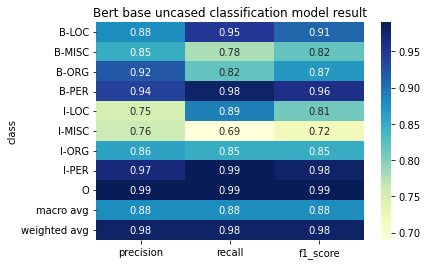

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = plt.axes()
sns.heatmap(classification_report_to_df(classification_report(labels_conll, predictions_conll)), ax = ax, annot = True, cmap="YlGnBu")
ax.set_title('Bert base uncased classification model result')

### Save the model for further use

In [ ]:
import os

directory = "./supervised_ner_Conll"

if not os.path.exists(directory):
    os.makedirs(directory)

# save vocabulary of the tokenizer
tokenizer.save_vocabulary(directory)
# save the model weights and its configuration file
model.save_pretrained(directory)
print('Supervised NER Conll model saved')

Supervised NER Conll model saved


## On Ritter's Dataset (Twitter)

### Data Loading

In [ ]:
ritter_ner = drive.CreateFile({'id':'1K4SDpp5kWtxI3DJaoBQA-7KNCPQqa9i1'}) 
ritter_ner.GetContentFile('Ritter_ner.txt')

### Data preprocessing

In [ ]:
with open("Ritter_ner.txt") as f:
  ritter_ner = f.readlines()

In [ ]:
def get_raw_df_ritter(txt_list):
  i = 1
  all_list = [token.split() for token in txt_list]
  for l in all_list:
    if l == []:
      i += 1
    else:
      l.append(f'sentence {i}')
  all_list = [x for x in all_list if x]
  df = pd.DataFrame(all_list, columns=["id", "ner_tags", "sentence number"])
  return df

In [ ]:
df_ritter_ner = get_raw_df_ritter(ritter_ner)
df_ritter_ner

,id,ner_tags,sentence number
0,@paulwalk,O,sentence 1
1,It,O,sentence 1
2,'s,O,sentence 1
3,the,O,sentence 1
4,view,O,sentence 1
...,...,...,...
46464,...,O,sentence 2394
46465,come,O,sentence 2394
46466,get,O,sentence 2394
46467,some,O,sentence 2394


In [ ]:
df_ritter_ner["ner_tags"].value_counts()

O                44007
B-person           449
I-other            320
B-geo-loc          276
B-other            225
I-person           215
B-company          171
I-facility         105
B-facility         104
B-product           97
I-product           80
I-musicartist       61
B-musicartist       55
B-sportsteam        51
I-geo-loc           49
I-movie             46
I-company           36
B-movie             34
B-tvshow            34
I-tvshow            31
I-sportsteam        23
Name: ner_tags, dtype: int64

In [ ]:
labels_to_ids = {}
for index, tag in enumerate(df_ritter_ner["ner_tags"].unique()):
  labels_to_ids [tag] = index
ids_to_labels = dict((v,k) for k,v in labels_to_ids.items())

In [ ]:
labels_to_ids

{'B-company': 5,
 'B-facility': 1,
 'B-geo-loc': 10,
 'B-movie': 11,
 'B-musicartist': 16,
 'B-other': 3,
 'B-person': 6,
 'B-product': 14,
 'B-sportsteam': 8,
 'B-tvshow': 7,
 'I-company': 15,
 'I-facility': 2,
 'I-geo-loc': 18,
 'I-movie': 12,
 'I-musicartist': 17,
 'I-other': 4,
 'I-person': 9,
 'I-product': 19,
 'I-sportsteam': 20,
 'I-tvshow': 13,
 'O': 0}

In [ ]:
ids_to_labels

{0: 'O',
 1: 'B-facility',
 2: 'I-facility',
 3: 'B-other',
 4: 'I-other',
 5: 'B-company',
 6: 'B-person',
 7: 'B-tvshow',
 8: 'B-sportsteam',
 9: 'I-person',
 10: 'B-geo-loc',
 11: 'B-movie',
 12: 'I-movie',
 13: 'I-tvshow',
 14: 'B-product',
 15: 'I-company',
 16: 'B-musicartist',
 17: 'I-musicartist',
 18: 'I-geo-loc',
 19: 'I-product',
 20: 'I-sportsteam'}

In [ ]:
df_ritter_ner["sentence"] = df_ritter_ner[["sentence number", "id", "ner_tags"]].groupby(["sentence number"])["id"].transform(lambda x: " ".join(x))
df_ritter_ner["labels"] = df_ritter_ner[["sentence number", "id", "ner_tags"]].groupby(["sentence number"])["ner_tags"].transform(lambda x: " ".join(x))

In [ ]:
def get_sentence_labels(raw_df):
  return raw_df[["sentence", "labels"]].drop_duplicates().reset_index(drop=True)
df_ritter_ner = get_sentence_labels(df_ritter_ner)
df_ritter_ner

,sentence,labels
0,@paulwalk It 's the view from where I 'm livin...,O O O O O O O O O O O O O O B-facility I-facil...
1,From Green Newsfeed : AHFA extends deadline fo...,O O O O B-other O O O B-other I-other O O O O O
2,Pxleyes Top 50 Photography Contest Pictures of...,B-company O O O O O O O O O O O
3,today is my last day at the office .,O O O O O O O O O
4,"4Dbling 's place til monday , party party part...",B-person O O O O O O O O O O O
...,...,...
2304,Parking Day - Parking Day hosted by the Hudson...,B-other I-other O B-other I-other O O O B-othe...
2305,Five Bullpens to Stay Away From in MLB Odds : ...,O O O O O O O B-other O O O O O O O O O O O O ...
2306,New Dorky Stuff : Friday Review Rundown ! Sept...,O O O O O O O O O O O O O O O O O O O O O O O ...
2307,"Oh PEI , i always forget how beautiful you are...",O B-person O O O O O O O O O O O O O O O O O O


In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_ritter_ner, test_size=0.3, random_state=42, shuffle=True)

In [ ]:
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [ ]:
print(f"Length of train dataset: {len(df_train)}, Length of test dataset: {len(df_test)} ")

Length of train dataset: 1616, Length of test dataset: 693 


### Change dataframe to PyTorch tensors

In [ ]:
class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels 
        sentence = self.data.sentence[index].strip().split()  
        word_labels = self.data.labels[index].split() 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True, #no is_pretokenlized(Modification), we already have a splitted sentence
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [labels_to_ids[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

### Training Model

In [ ]:
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        #loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
        output = model(input_ids=ids, attention_mask=mask, labels=labels)
        tr_loss += output[0]

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = output[1].view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        output[0].backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

### Testing Model

In [ ]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            #loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
            output = model(input_ids=ids, attention_mask=mask, labels=labels)

            eval_loss += output[0].item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = output[1].view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

### a. BERT NER Model

#### Build the model

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 3
VALID_BATCH_SIZE = 2
EPOCHS = 4
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased') #Bert using wordpiece *** may improve further

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
training_set = dataset(df_train, tokenizer, MAX_LEN)
#validation_set = dataset(df_valid, tokenizer, MAX_LEN)
testing_set = dataset(df_test, tokenizer, MAX_LEN)

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(ids_to_labels))

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu' #save the processing time
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

#### Train the model

In [ ]:
for epoch in range(EPOCHS):
  print(f"Training epoch: {epoch + 1}")
  train(epoch)

Training epoch: 1
Training loss per 100 training steps: 3.2053580284118652
Training loss per 100 training steps: 0.7151978611946106
Training loss per 100 training steps: 0.5186008810997009
Training loss per 100 training steps: 0.4261421263217926
Training loss per 100 training steps: 0.38600337505340576
Training loss per 100 training steps: 0.3660792112350464
Training loss epoch: 0.35292571783065796
Training accuracy epoch: 0.9350766413278727
Training epoch: 2
Training loss per 100 training steps: 0.4920268654823303
Training loss per 100 training steps: 0.1951124668121338
Training loss per 100 training steps: 0.19880236685276031
Training loss per 100 training steps: 0.18760326504707336
Training loss per 100 training steps: 0.18381978571414948
Training loss per 100 training steps: 0.18635325133800507
Training loss epoch: 0.18115870654582977
Training accuracy epoch: 0.9565737542448804
Training epoch: 3
Training loss per 100 training steps: 0.23305030167102814
Training loss per 100 trainin

#### Test the model

In [ ]:
labels_Ritter_BERT, predictions_Ritter_BERT = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.10544943064451218
Validation loss per 100 evaluation steps: 0.13133742228971038
Validation loss per 100 evaluation steps: 0.1415262956265476
Validation loss per 100 evaluation steps: 0.1374856083243126
Validation Loss: 0.1405220003233302
Validation Accuracy: 0.9688758589574363


#### Produce the classification report

In [ ]:
print(classification_report(labels_Ritter_BERT, predictions_Ritter_BERT))

               precision    recall  f1-score   support

    B-company       0.71      0.63      0.67        43
   B-facility       0.49      0.61      0.54        28
    B-geo-loc       0.64      0.79      0.71        73
      B-movie       0.00      0.00      0.00         4
B-musicartist       1.00      0.06      0.11        18
      B-other       0.45      0.39      0.42        70
     B-person       0.80      0.86      0.83       133
    B-product       0.34      0.33      0.34        30
 B-sportsteam       0.37      0.64      0.47        11
     B-tvshow       0.00      0.00      0.00        13
    I-company       0.33      0.29      0.31         7
   I-facility       0.70      0.66      0.68        35
    I-geo-loc       0.60      0.38      0.46         8
      I-movie       0.00      0.00      0.00         9
I-musicartist       0.62      0.26      0.37        19
      I-other       0.49      0.44      0.47        99
     I-person       0.80      0.84      0.82        57
    I-pro

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd

def classification_report_to_df(report):
    report_data = report.splitlines()
    report_data = [report.split() for report in report_data]
    report = []
    for line in report_data[2:-4]:
      row = {}
      row['class'] = line[0]
      row['precision'] = float(line[1])
      row['recall'] = float(line[2])
      row['f1_score'] = float(line[3])   
      report.append(row)
    
    report.append({'class': report_data[-2][0] + " " + report_data[-2][1], 
                   'precision': float(report_data[-2][2]), 
                   'recall': float(report_data[-2][3]),
                   'f1_score': float(report_data[-2][4])})

    report.append({'class': report_data[-1][0] + " " + report_data[-2][1],  
                   'precision': float(report_data[-1][2]), 
                   'recall': float(report_data[-1][3]),
                   'f1_score': float(report_data[-1][4])})
    
    dataframe = pd.DataFrame.from_dict(report)
    dataframe = dataframe.set_index('class', drop = True)
    return dataframe

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, "Bert base uncased classification model result for Ritter's dataset")

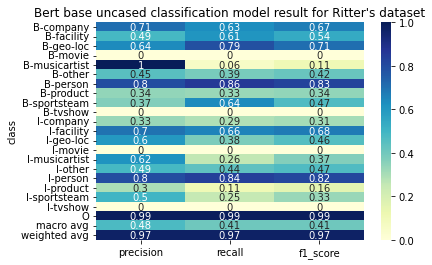

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = plt.axes()
sns.heatmap(classification_report_to_df(classification_report(labels_Ritter_BERT, predictions_Ritter_BERT)), 
            ax = ax, annot = True, cmap="YlGnBu",  xticklabels=True, yticklabels=True)
ax.set_title('Bert base uncased classification model result for Ritter\'s dataset')

#### Save the model for further use

In [ ]:
import os

directory = "./supervised_ner_Ritter_BERT"

if not os.path.exists(directory):
    os.makedirs(directory)

# save vocabulary of the tokenizer
tokenizer.save_vocabulary(directory)
# save the model weights and its configuration file
model.save_pretrained(directory)
print('Supervised ner Ritter BERT model saved')

Supervised ner Ritter BERT model saved


### b. BERTweet NER Model

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 3
VALID_BATCH_SIZE = 2
EPOCHS = 4
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
from transformers import RobertaTokenizer,RobertaTokenizerFast,RobertaForTokenClassification, AutoModelForTokenClassification
tokenizer = RobertaTokenizerFast.from_pretrained('vinai/bertweet-large', add_prefix_space=True) 
training_set = dataset(df_train, tokenizer, MAX_LEN)
#validation_set = dataset(df_valid, tokenizer, MAX_LEN)
testing_set = dataset(df_test, tokenizer, MAX_LEN)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/614 [00:00<?, ?B/s]

#### Build the model

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }
training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
model = RobertaForTokenClassification.from_pretrained('vinai/bertweet-large', num_labels=len(ids_to_labels))

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaForTokenClassification: ['lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN thi

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu' #save the processing time
model.to(device)

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
            

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

#### Train the model

In [ ]:
for epoch in range(EPOCHS):
  print(f"Training epoch: {epoch + 1}")
  train(epoch)

Training epoch: 1
Training loss per 100 training steps: 3.2838456630706787
Training loss per 100 training steps: 0.5181435942649841
Training loss per 100 training steps: 0.389159232378006
Training loss per 100 training steps: 0.32257410883903503
Training loss per 100 training steps: 0.2871592044830322
Training loss per 100 training steps: 0.26869454979896545
Training loss epoch: 0.25717559456825256
Training accuracy epoch: 0.9453115965500102
Training epoch: 2
Training loss per 100 training steps: 0.35437479615211487
Training loss per 100 training steps: 0.10937780141830444
Training loss per 100 training steps: 0.11117689311504364
Training loss per 100 training steps: 0.10796783119440079
Training loss per 100 training steps: 0.10358598828315735
Training loss per 100 training steps: 0.10113190859556198
Training loss epoch: 0.09802726656198502
Training accuracy epoch: 0.9734312031487152
Training epoch: 3
Training loss per 100 training steps: 0.6107842326164246
Training loss per 100 traini

#### Test the model

In [ ]:
labels_Ritter_BERTweet, predictions_Ritter_BERTweet = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.5299917459487915
Validation loss per 100 evaluation steps: 0.12118697238615328
Validation loss per 100 evaluation steps: 0.12795654554501745
Validation loss per 100 evaluation steps: 0.11839614469822497
Validation Loss: 0.11771198388910424
Validation Accuracy: 0.9767497167958574


#### Produce the classification report

In [ ]:
import pandas as pd

def classification_report_to_df(report):
    report_data = report.splitlines()
    report_data = [report.split() for report in report_data]
    report = []
    for line in report_data[2:-4]:
      row = {}
      row['class'] = line[0]
      row['precision'] = float(line[1])
      row['recall'] = float(line[2])
      row['f1_score'] = float(line[3])   
      report.append(row)
    
    report.append({'class': report_data[-2][0] + " " + report_data[-2][1], 
                   'precision': float(report_data[-2][2]), 
                   'recall': float(report_data[-2][3]),
                   'f1_score': float(report_data[-2][4])})

    report.append({'class': report_data[-1][0] + " " + report_data[-2][1],  
                   'precision': float(report_data[-1][2]), 
                   'recall': float(report_data[-1][3]),
                   'f1_score': float(report_data[-1][4])})
    
    dataframe = pd.DataFrame.from_dict(report)
    dataframe = dataframe.set_index('class', drop = True)
    return dataframe

In [ ]:
print(classification_report(labels_Ritter_BERTweet, predictions_Ritter_BERTweet))

               precision    recall  f1-score   support

    B-company       0.69      0.79      0.74        43
   B-facility       0.73      0.68      0.70        28
    B-geo-loc       0.72      0.79      0.76        73
      B-movie       0.43      0.75      0.55         4
B-musicartist       0.67      0.22      0.33        18
      B-other       0.69      0.57      0.62        70
     B-person       0.75      0.95      0.84       133
    B-product       0.53      0.60      0.56        30
 B-sportsteam       0.50      1.00      0.67        11
     B-tvshow       1.00      0.46      0.63        13
    I-company       0.67      0.57      0.62         7
   I-facility       0.70      0.60      0.65        35
    I-geo-loc       0.43      0.38      0.40         8
      I-movie       0.50      0.78      0.61         9
I-musicartist       0.77      0.53      0.62        19
      I-other       0.76      0.47      0.58        99
     I-person       0.82      0.95      0.88        57
    I-pro

Text(0.5, 1.0, "Bert base uncased classification model result for Ritter's dataset")

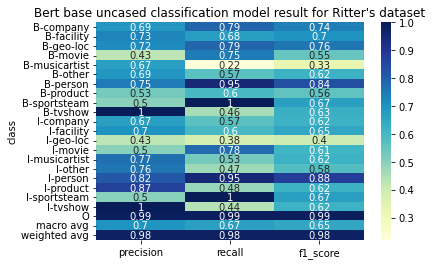

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = plt.axes()
sns.heatmap(classification_report_to_df(classification_report(labels_Ritter_BERTweet, predictions_Ritter_BERTweet)),
            ax = ax, annot = True, cmap="YlGnBu", xticklabels=True, yticklabels=True)
ax.set_title('Bert base uncased classification model result for Ritter\'s dataset')

#### Save the model for further use

In [ ]:
import os

directory = "./supervised_ner_Ritter_BERTweet"

if not os.path.exists(directory):
    os.makedirs(directory)

# save vocabulary of the tokenizer
tokenizer.save_vocabulary(directory)
# save the model weights and its configuration file
model.save_pretrained(directory)
print('Supervised ner Ritter BERTweet model saved')

Supervised ner Ritter BERTweet model saved


### c. Roberta NER Model

In [ ]:
from transformers import RobertaTokenizer,RobertaTokenizerFast,RobertaForTokenClassification, AutoModelForTokenClassification
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', add_prefix_space=True) 
training_set = dataset(df_train, tokenizer, MAX_LEN)
#validation_set = dataset(df_valid, tokenizer, MAX_LEN)
testing_set = dataset(df_test, tokenizer, MAX_LEN)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

#### Build the model

In [ ]:
training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
model = RobertaForTokenClassification.from_pretrained('roberta-base', num_labels=len(ids_to_labels))

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu' #save the processing time
model.to(device)

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

#### Train the model

In [ ]:
for epoch in range(EPOCHS):
  print(f"Training epoch: {epoch + 1}")
  train(epoch)

Training epoch: 1
Training loss per 100 training steps: 2.859989643096924
Training loss per 100 training steps: 0.5848017930984497
Training loss per 100 training steps: 0.43301576375961304
Training loss per 100 training steps: 0.3603156805038452
Training loss per 100 training steps: 0.32666879892349243
Training loss per 100 training steps: 0.3105521500110626
Training loss epoch: 0.29832011461257935
Training accuracy epoch: 0.9433219248816433
Training epoch: 2
Training loss per 100 training steps: 0.3505789637565613
Training loss per 100 training steps: 0.14381806552410126
Training loss per 100 training steps: 0.14950159192085266
Training loss per 100 training steps: 0.14194345474243164
Training loss per 100 training steps: 0.13786344230175018
Training loss per 100 training steps: 0.140745148062706
Training loss epoch: 0.1368894726037979
Training accuracy epoch: 0.964615101411616
Training epoch: 3
Training loss per 100 training steps: 0.07763605564832687
Training loss per 100 training s

#### Test the model

In [ ]:
labels_Ritter_Roberta, predictions_Ritter_Roberta = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.3359372615814209
Validation loss per 100 evaluation steps: 0.11412960006181141
Validation loss per 100 evaluation steps: 0.12913376868317894
Validation loss per 100 evaluation steps: 0.12469602070293974
Validation Loss: 0.12301125950552388
Validation Accuracy: 0.9718627622185402


#### Produce the classification report

In [ ]:
print(classification_report(labels_Ritter_Roberta, predictions_Ritter_Roberta))

               precision    recall  f1-score   support

    B-company       0.61      0.77      0.68        43
   B-facility       0.65      0.54      0.59        28
    B-geo-loc       0.62      0.86      0.72        73
      B-movie       0.00      0.00      0.00         4
B-musicartist       0.67      0.11      0.19        18
      B-other       0.46      0.39      0.42        70
     B-person       0.82      0.86      0.84       133
    B-product       0.82      0.47      0.60        30
 B-sportsteam       0.59      0.91      0.71        11
     B-tvshow       1.00      0.15      0.27        13
    I-company       0.12      0.14      0.13         7
   I-facility       0.68      0.49      0.57        35
    I-geo-loc       0.36      0.50      0.42         8
      I-movie       0.00      0.00      0.00         9
I-musicartist       0.54      0.37      0.44        19
      I-other       0.56      0.44      0.49        99
     I-person       0.89      0.86      0.88        57
    I-pro

Text(0.5, 1.0, "Bert base uncased classification model result for Ritter's dataset")

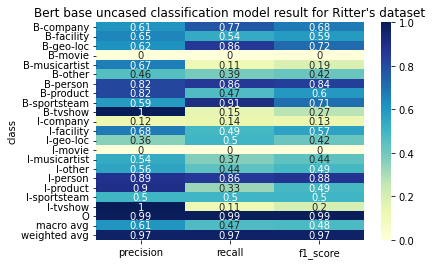

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = plt.axes()
sns.heatmap(classification_report_to_df(classification_report(labels_Ritter_Roberta, predictions_Ritter_Roberta)), ax = ax, annot = True, cmap="YlGnBu",  xticklabels=True, yticklabels=True)
ax.set_title('Bert base uncased classification model result for Ritter\'s dataset')

#### Save the model for further use

In [ ]:
import os

directory = "./supervised_ner_Ritter_Roberta"

if not os.path.exists(directory):
    os.makedirs(directory)

# save vocabulary of the tokenizer
tokenizer.save_vocabulary(directory)
# save the model weights and its configuration file
model.save_pretrained(directory)
print('Supervised ner Ritter Roberta model saved')

Supervised ner Ritter Roberta model saved


# 2. Semi-supervised self training model



1.   df_train is the raw dataframe without annotated labels so we fake the labels to get the same template as before
2.   use the saved model to make prediction of df_train: here we used the Bertweet-large model as it has the best performance among those three models
3.   use softmax to transfer logits into probability and compute the average probability for each sentence
4.   choose sentences with the top percent confidence and replace the true annotated labels of the sentences with predicted lables as the new training set 
5.   the other sentences with less prediction confidence would be set as the next prediction set for next iteration
6.   train the saved model with the new training set, update the model and save the new model
7.   Use the new model to make predictions using the saved new model and select training set again
8.   Iteratively continue the process until a "stop point"
9.   To determine the stop point, we need to iteratively run the process and use a plot to compute the training accuracy
10.  Test on the original dataset to have a comparable result



## Data preprocessing

In [ ]:
unlabelled_tweets = drive.CreateFile({'id':"10uXMY92VXdIorTIiKc_D3BeyzFBglZKE"})
unlabelled_tweets.GetContentFile("st_tweets.txt")

In [ ]:
with open("st_tweets.txt") as f:
  new_tweets = f.readlines()

In [ ]:
def get_raw_df(txt_list):
  i = 1
  all_list = [token.split() for token in txt_list]
  for l in all_list:
    if l == []:
      i += 1
    else:
      l.append(f'sentence {i}')
  all_list = [x for x in all_list if x]
  df = pd.DataFrame(all_list, columns=["id", "ner_tags", "sentence number"])
  return df
nt = get_raw_df(new_tweets)

In [ ]:
nt["sentence"] = nt[["sentence number", "id", "ner_tags"]].groupby(["sentence number"])["id"].transform(lambda x: " ".join(x))
nt["labels"] = nt[["sentence number", "id", "ner_tags"]].groupby(["sentence number"])["ner_tags"].transform(lambda x: " ".join(x))

In [ ]:
def get_sentence_labels(raw_df):
  return raw_df[["sentence", "labels"]].drop_duplicates().reset_index(drop=True)
df_train = get_sentence_labels(nt)
df_train

,sentence,labels
0,"I hate the words chunder , vomit and puke . BU...",O O O O O O O O O O O O
1,♥ . . ) ) ( ♫ . ( ) ♫ . ♥ . « ▓ » ♥ . ♫ . . ╝ ...,O O O O O O O O O O O O O O O O O O O O O O O ...
2,Alesan kenapa mlm kita lbh srg galau Poconggg ...,O O O O O O O O O O O O O O O O O O O O O O O ...
3,Complete Tosca on the tube http://t.co/O90deSLB,O O O O O O
4,Think you call that smash and grab . # Gateshe...,O O O O O O O O O B-LOC O O O O O O O O O O O ...
...,...,...
2995,You would prefer to be creative on your own te...,O O O O O O O O O O O O O O O O O B-ORG O
2996,does anyone else have an influx of local vouch...,O O O O O O O O O O O O O O O O O O O O O O O ...
2997,"Music from The Succubus Club , get in my ears !",O O B-ORG I-ORG I-ORG O O O O O O
2998,Disturbing London !,O B-LOC O


In [ ]:
def label_sim(x):
  temp = x.split(" ")
  new = list()
  for i in temp:
    new.append("O")
  return " ".join(new)

In [ ]:
df_train["labels"] = df_train["labels"].apply(lambda x: label_sim(x))
df_train

,sentence,labels
0,"I hate the words chunder , vomit and puke . BU...",O O O O O O O O O O O O
1,♥ . . ) ) ( ♫ . ( ) ♫ . ♥ . « ▓ » ♥ . ♫ . . ╝ ...,O O O O O O O O O O O O O O O O O O O O O O O ...
2,Alesan kenapa mlm kita lbh srg galau Poconggg ...,O O O O O O O O O O O O O O O O O O O O O O O ...
3,Complete Tosca on the tube http://t.co/O90deSLB,O O O O O O
4,Think you call that smash and grab . # Gateshe...,O O O O O O O O O O O O O O O O O O O O O O O ...
...,...,...
2995,You would prefer to be creative on your own te...,O O O O O O O O O O O O O O O O O O O
2996,does anyone else have an influx of local vouch...,O O O O O O O O O O O O O O O O O O O O O O O ...
2997,"Music from The Succubus Club , get in my ears !",O O O O O O O O O O O
2998,Disturbing London !,O O O


In [ ]:
df_test

,sentence,labels
0,RT @BomadeBeverage #TEAMBOMADE everywhere ! to...,O O O O O O O O O O O B-facility I-facility I-...
1,@amandaguido i didnt sseee you today :(,O O O O O O O
2,@bakontrack I was on a successful business tri...,O O O O O O O O O O O O O O O O
3,What Do S.F. Rabbis Eat Before and After Yom K...,O O B-geo-loc O O O O O B-other I-other O O O ...
4,@halbpro it 's simple to get two films worth o...,O O O O O O O O O O O O O O O O O O O O O O O ...
...,...,...
688,Was hard work going to the gym on my own tonig...,O O O O O O O O O O O O O O O O O O O O O O O ...
689,"Mac Sync Completed - September 17 , 2010 , 5:0...",O O O O O O O O O O O
690,@webcowgirl You're supposed to fast after sund...,O O O O O O O O O O
691,@CHRIS_Daughtry Aw ur cute when u get mad ur s...,O O O O O O O O O O O O O O O O O O O O O O O ...


## functions to support self training models

### train function: train the model use the new training set

In [ ]:
def train(epoch):
  
    """train the model use the training set"""

    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        from sklearn.metrics import accuracy_score
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        #loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
        output = model(input_ids=ids, attention_mask=mask, labels=labels)
        tr_loss += output[0]

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = output[1].view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        output[0].backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

### test function: test the model use the original dataset(ritter's)

In [ ]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            from sklearn.metrics import accuracy_score
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            #loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
            output = model(input_ids=ids, attention_mask=mask, labels=labels)

            eval_loss += output[0].item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = output[1].view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")
    return eval_accuracy

### prediction function: use the model to predict each label of the sentence in the dataset

In [ ]:
def prediction(model, data_loader):
    """use the model to predict each label of the sentence in the dataset"""

    all_sentences = []
    with torch.no_grad():
        for idx, batch in enumerate(data_loader):
            sentence_prediction = {}
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)

            #loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
            output = model(input_ids=ids, attention_mask=mask, labels=labels)
 
            if idx % 300==0:
                print(f"Finished predicting {idx} sentences")
            
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = output[1].view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # compute active probability using softmax function
            active_probability = torch.nn.functional.softmax(active_logits, dim=1)
            flattened_probability = torch.argmax(active_probability, axis=1)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)

            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            probabilities = torch.masked_select(flattened_probability, active_accuracy)
            masks = torch.masked_select(mask, active_accuracy).tolist()
            input_ids = torch.masked_select(ids, active_accuracy).tolist()

            #get probability scores
            prob_score = []
            for ind, prob in enumerate(probabilities):
              prob_score.append(float(active_probability[ind][prob]))
            
            sentence_prediction["Attention masks"] = masks
            sentence_prediction["Input ids"] = input_ids
            sentence_prediction["Token"] = [tokenizer.convert_ids_to_tokens(input_id) for input_id in input_ids]
            sentence_prediction["Actual labels"] = [ids_to_labels[int(x)] for x in labels]
            sentence_prediction["Probability"] = [x for x in prob_score]
            sentence_prediction["Predicted labels"] = [ids_to_labels[int(x)] for x in predictions]
            sentence_prediction["Sentence number"] = [idx] * len(input_ids)
            all_sentences.append(sentence_prediction)

    return all_sentences

### get_data: get the average probability of each sentence with labels predicted for each iteration

In [ ]:
def get_data(iteration_time, model_name):

  """Function to get the average probability of each sentence with labels predicted for each iteration"""

  #load csv file saved before
  df_predictions = pd.read_csv(f"./unsupervised_selftraining_{model_name}_iteration_{iteration_time-1}/processed_data_{iteration_time - 1}.csv")
  df_predictions = df_predictions.drop(columns=['Unnamed: 0'])
  
  #change the type of the data into what they should be before saved into csv files
  import ast
  for column in list(df_predictions.columns):
    df_predictions[column] = df_predictions[column].apply(ast.literal_eval)

  #get the average predicted probability of each sentence to find the most confident sentences
  df_predictions["Average probability"] = df_predictions["Probability"].apply(np.mean)

  return df_predictions

### new split: get the next training set and dataset for prediction using top percent as selection criteria

In [ ]:
def new_split(df_train, iteration_time, model_name, top_percent = 0.10):

  """Function to get the next training set and dataset for prediction using top percent as selection criteria"""
  
  import math
  df_predictions = get_data(iteration_time, model_name)
  #get sentences with predicted labels and replace the original true labels with the predicted most confident labels
  df_train["labels"] = df_predictions["Predicted labels"].str.join(" ")

  #sort the dataframe by average probability of each sentence to get the most confident sentence
  df_predictions = df_predictions.sort_values(by=['Average probability'], ascending=False)

  #use the top percent confident sentences as the new training set
  df_new_train = df_predictions.iloc[:(math.ceil(len(df_predictions) * top_percent)) + 1, : ]

  #treat the less confident sentences as the new dataset to be predicted using the updated model for next iteration
  df_prediction = df_predictions.iloc[(math.ceil(len(df_predictions) * top_percent)) + 1:, : ]

  #find the ids of those sentences from the original dataset
  df_train_id = list(df_new_train.index)
  df_prediction_id = list(df_prediction.index)

  #truncate the original dataset and get the new training and prediction data frame
  new_train = df_train.take(df_train_id)
  new_prediction = df_train.take(df_prediction_id)
  new_train = new_train.reset_index(drop=True)
  new_prediction = new_prediction.reset_index(drop=True)

  return new_train, new_prediction

### create_dir: create directory to save the model and tokenizer

In [ ]:
def create_dir(i, tokenizer, model, model_name):

  """create directory to save the model and tokenizer"""

  directory_0 = f'./unsupervised_selftraining_{model_name}_iteration_{i}'
  directory_1 = f'./unsupervised_selftraining_{model_name}_iteration_{i}/model'

  if not os.path.exists(directory_0):
    os.makedirs(directory_0)

  if not os.path.exists(directory_1):
    os.makedirs(directory_1)

  # save vocabulary of the tokenizer
  tokenizer.save_vocabulary(directory_1)
  # save the model weights and its configuration file
  model.save_pretrained(directory_1)

### update_model: use the new training set to update the model and create directory for the updated model and tokenizer

In [ ]:
def update_model(new_train, tokenizer, iteration_time, model_name):

  for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)
  
  create_dir(iteration_time, tokenizer, model, model_name)
  
  print(f'iteration {iteration_time} updated model saved')

### self_training_model: iteratively conduct the self training process after indication the training set, pretrained model, top percent to select and the total iteration times

In [ ]:
def self_training_model(df_train, df_test, pretrained_model_path, model_name, top_percent = 0.20, total_iterations = 25):

  """Iteratively conduct the self training process after indication the training set, supervised pretrained model, top percent to select and the total iteration times"""

  #save the iteration time and training accuracy as a dictionary for further hyperparameter selection
  result = dict()

  for i in range(total_iterations):
    print("==========================================================================")
    print(f"ITERATION {i} STARTS!")
    
    #zero-shot prediction
    if i == 0:
      #load the tokenizer saved from the supervised model previously
      tokenizer = AutoTokenizer.from_pretrained(pretrained_model_path, add_prefix_space=True)
      print(f"tokenizer before iteration {i} loaded") 

      #load the model saved from the supervised model previously
      model = AutoModelForTokenClassification.from_pretrained(pretrained_model_path)
      print(f"model before iteration {i} loaded")
      model.to(device)
      
      print(f"model testing score before iteration {i}")
      #get the original accuracy score on the test set
      #testing_set = dataset(df_test, tokenizer, MAX_LEN)
      #testing_loader = DataLoader(testing_set, **params)
      #test_accuracy_score = valid(model, testing_loader)
      #result[i] = test_accuracy_score
      
      #save the model and tokenizer in directory for further use
      create_dir(i, tokenizer, model, model_name)
      print(f'tokenizer and model saved after {i} iteration')
      
      #get rid of the data containing special symbol that the current tokenizer cannot deal with
      training_set = dataset(df_train, tokenizer, MAX_LEN)
      training_loader = DataLoader(training_set, **params)
      invalid = []
      for ind in range(len(training_set)):
        try:
          training_set[ind]
        except:
          invalid.append(ind)
      df_train = df_train.drop(invalid)
      df_train = df_train.reset_index(inplace = False).drop(columns = "index")
      
      #set the training
      training_set = dataset(df_train, tokenizer, MAX_LEN)
      training_loader = DataLoader(training_set, **params)

      predictions = prediction(model, training_loader)
      predictions = pd.DataFrame(predictions)
      #save_directory(predictions, iteration_time = i)
      predictions.to_csv(f"./unsupervised_selftraining_{model_name}_iteration_{i}/processed_data_{i}.csv") 
      print(f'Iteration {i} Prediction data saved')
      print(f'ITERATION {i} ENDS!')
    
    #iteration starts
    else:
      model_previous = f'./unsupervised_selftraining_{model_name}_iteration_{i - 1}/model'
      tokenizer = AutoTokenizer.from_pretrained(model_previous, add_prefix_space=True)
      model = AutoModelForTokenClassification.from_pretrained(model_previous)
      model.to(device)
      optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

      #get the top percent most confident predictions from sentences and replace the labels with predictions
      new_train, new_prediction = new_split(df_train, i, model_name, top_percent)
      training_set = dataset(new_train, tokenizer, MAX_LEN)
      training_loader = DataLoader(training_set, **params)

      #update the training model
      update_model(new_train, tokenizer, i, model_name)
      print(f"Model updated for iteration {i}")

      print(f"Model testing score after iteration {i}:")
      #get the original accuracy score on the test set
      testing_set = dataset(df_test, tokenizer, MAX_LEN)
      testing_loader = DataLoader(testing_set, **params)
      test_accuracy_score = valid(model, testing_loader)
      result[i] = test_accuracy_score

      df_train = new_prediction
      training_set = dataset(df_train, tokenizer, MAX_LEN)
      training_loader = DataLoader(training_set, **params)
      
      predictions = prediction(model, training_loader)
      predictions = pd.DataFrame(predictions)
      
      #save_directory(predictions, iteration_time = i)
      predictions.to_csv(f"./unsupervised_selftraining_{model_name}_iteration_{i}/processed_data_{i}.csv") 
      print(f'Iteration {i} Prediction data saved')
      print(f'ITERATION {i} ENDS!')
  return result

### accuracy_to_df: get a dataframe showing iteration time and the training accuracy 

In [ ]:
def accuracy_to_df(result, top_percent = 0.10):
  df_accuracy = pd.DataFrame()
  key = list(result.keys())
  value = list(result.values())
  df_accuracy["Iteration times"] = key
  df_accuracy[f"Testing accuracy({round(top_percent*100)}%)"] = value
  df_accuracy[f"Testing accuracy({round(top_percent*100)}%)"] = round(df_accuracy[f"Testing accuracy({round(top_percent*100)}%)"], 6)
  return df_accuracy

### visualize_accuracy: visualize the training accuracy vs times of iteration for top percent selected

In [ ]:
def visualize_accuracy(df_accuracy, top_percent):

  import matplotlib.pyplot as plt
  from matplotlib.figure import Figure
  from matplotlib.ticker import MaxNLocator
  x = df_accuracy.iloc[:, 0]
  y = df_accuracy.iloc[:, 1]

  plt.plot(x, y,marker="o")
  plt.xticks(x,x)
  plt.title(f"Testing accuracy vs Times of iteration for top {round(top_percent*100)}%")
  plt.xlabel("Times of iteration")
  plt.ylabel("Testing accuracy")
  plt.savefig(f"Accuracy_Iteration_{round(top_percent*100)}.jpg")
  plt.show()

## Self training iterative models

#### 1. top 5 percent confident sentences model with 30 iterations

In [ ]:
EPOCHS = 1
params = {'batch_size': 1, 'shuffle': False, 'num_workers': 0}
pretrained_model_path = "./supervised_ner_Ritter_BERTweet"
total_iterations = 30
model_name = "BERTweet_1"
top_percent_1 = 0.05

accuracy_1 = self_training_model(df_train, df_test, pretrained_model_path, model_name, top_percent_1, total_iterations)

ITERATION 0 STARTS!
tokenizer before iteration 0 loaded
model before iteration 0 loaded
model testing score before iteration 0
tokenizer and model saved after 0 iteration
Finished predicting 0 sentences
Finished predicting 300 sentences
Finished predicting 600 sentences
Finished predicting 900 sentences
Finished predicting 1200 sentences
Finished predicting 1500 sentences
Finished predicting 1800 sentences
Finished predicting 2100 sentences
Finished predicting 2400 sentences
Finished predicting 2700 sentences
Iteration 0 Prediction data saved
ITERATION 0 ENDS!
ITERATION 1 STARTS!
Training epoch: 1
Training loss per 100 training steps: 0.050301045179367065
Training loss per 100 training steps: 0.04949723929166794
Training loss per 100 training steps: 0.05333825945854187
Training loss per 100 training steps: 0.05338815599679947
Training loss per 100 training steps: 0.050033122301101685
Training loss per 100 training steps: 0.04926107078790665
Training loss epoch: 0.047723036259412766
Tra

##### 1.1 each iteration's accuracy

In [ ]:
accuracy_1 = accuracy_to_df(accuracy_1, top_percent_1)
accuracy_1

,Iteration times,Testing accuracy(5%)
0,1,0.976485
1,2,0.970379
2,3,0.971540
3,4,0.971912
4,5,0.972446
5,6,0.972360
6,7,0.972638
7,8,0.973909
8,9,0.974183
9,10,0.967749


##### 1.2 accuracy visualization

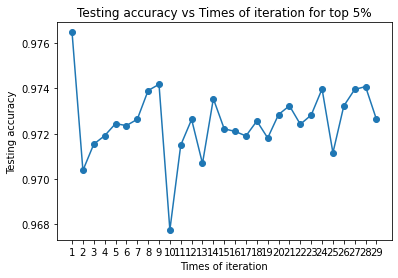

In [ ]:
visualize_accuracy(accuracy_1, top_percent_1)

#### 2. top 10 percent confident sentences model with 30 iterations

In [ ]:
EPOCHS = 1
params = {'batch_size': 1, 'shuffle': False, 'num_workers': 0}
pretrained_model_path = "./supervised_ner_Ritter_BERTweet"
total_iterations = 30
model_name = "BERTweet_2"
top_percent_2 = 0.10

accuracy_2 = self_training_model(df_train, df_test, pretrained_model_path, model_name, top_percent_2, total_iterations)

ITERATION 0 STARTS!
tokenizer before iteration 0 loaded
model before iteration 0 loaded
model testing score before iteration 0
tokenizer and model saved after 0 iteration
Finished predicting 0 sentences
Finished predicting 300 sentences
Finished predicting 600 sentences
Finished predicting 900 sentences
Finished predicting 1200 sentences
Finished predicting 1500 sentences
Finished predicting 1800 sentences
Finished predicting 2100 sentences
Finished predicting 2400 sentences
Finished predicting 2700 sentences
Iteration 0 Prediction data saved
ITERATION 0 ENDS!
ITERATION 1 STARTS!
Training epoch: 1
Training loss per 100 training steps: 0.00024127385404426605
Training loss per 100 training steps: 0.004810284357517958
Training loss per 100 training steps: 0.01600310578942299
Training loss per 100 training steps: 0.013176359236240387
Training loss per 100 training steps: 0.014140196144580841
Training loss per 100 training steps: 0.012707745656371117
Training loss epoch: 0.01218425482511520

##### 2.1 each iteration's accuracy

In [ ]:
accuracy_2 = accuracy_to_df(accuracy_2, top_percent_2)
accuracy_2

,Iteration times,Testing accuracy(10%)
0,1,0.976485
1,2,0.970982
2,3,0.972401
3,4,0.970882
4,5,0.972574
5,6,0.972992
6,7,0.972778
7,8,0.971157
8,9,0.973139
9,10,0.971487


##### 2.2 result visualization

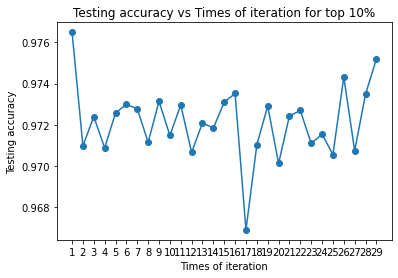

In [ ]:
visualize_accuracy(accuracy_2, top_percent_2)

#### 3. top 15 percent confident sentences model with 30 iterations

In [ ]:
EPOCHS = 1
params = {'batch_size': 1, 'shuffle': False, 'num_workers': 0}
pretrained_model_path = "./supervised_ner_Ritter_BERTweet"
total_iterations = 30
model_name = "BERTweet_3"
top_percent_3 = 0.15

accuracy_3 = self_training_model(df_train, df_test, pretrained_model_path, model_name, top_percent_3, total_iterations)

ITERATION 0 STARTS!
tokenizer before iteration 0 loaded
model before iteration 0 loaded
model testing score before iteration 0
tokenizer and model saved after 0 iteration
Finished predicting 0 sentences
Finished predicting 300 sentences
Finished predicting 600 sentences
Finished predicting 900 sentences
Finished predicting 1200 sentences
Finished predicting 1500 sentences
Finished predicting 1800 sentences
Finished predicting 2100 sentences
Finished predicting 2400 sentences
Finished predicting 2700 sentences
Iteration 0 Prediction data saved
ITERATION 0 ENDS!
ITERATION 1 STARTS!
Training epoch: 1
Training loss per 100 training steps: 9.29437082959339e-05
Training loss per 100 training steps: 0.0027923709712922573
Training loss per 100 training steps: 0.004017243627458811
Training loss per 100 training steps: 0.003086348529905081
Training loss per 100 training steps: 0.004064222797751427
Training loss per 100 training steps: 0.003816652810201049
Training loss epoch: 0.00355933234095573

##### 3.1 each iteration's accuracy

In [ ]:
accuracy_3 = accuracy_to_df(accuracy_3, top_percent_3)
accuracy_3

,Iteration times,Testing accuracy(15%)
0,1,0.976485
1,2,0.971887
2,3,0.973535
3,4,0.973093
4,5,0.968556
5,6,0.972614
6,7,0.972472
7,8,0.974188
8,9,0.974020
9,10,0.974508


##### 3.2 result visualization

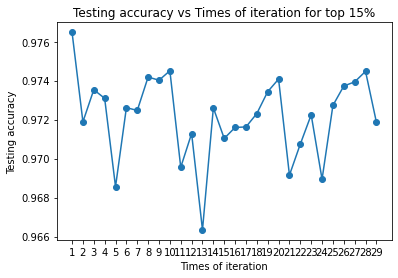

In [ ]:
visualize_accuracy(accuracy_3, top_percent_3)

## Models comparison and selection

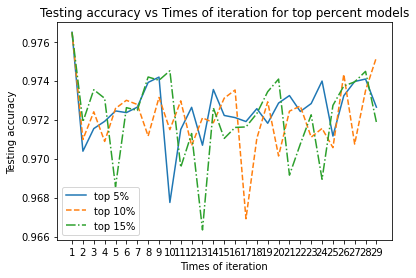

In [ ]:
import matplotlib.pyplot as plt
  
# create data
x = accuracy_1.iloc[:, 0]
a1 = accuracy_1.iloc[:, 1]
a2 = accuracy_2.iloc[:, 1]
a3 = accuracy_3.iloc[:, 1]
  
# plot lines
plt.plot(x, a1, label = "top 5%", linestyle="-")
plt.plot(x, a2, label = "top 10%", linestyle="--")
plt.plot(x, a3, label = "top 15%", linestyle="-.")
plt.xticks(x,x)
plt.title("Testing accuracy vs Times of iteration for top percent models")
plt.xlabel("Times of iteration")
plt.ylabel("Testing accuracy")
plt.savefig("Model Comparison.jpeg")
plt.legend()
plt.show()


The threee models show similar performances, so we would choose top 10% model for highest accuracy potential but we want to see whether the model performance can further appove after the 29th iteration, so we test another 1 iteration for an extension

In [ ]:
EPOCHS = 1
params = {'batch_size': 1, 'shuffle': False, 'num_workers': 0}
pretrained_model_path = "./unsupervised_selftraining_BERTweet_2_iteration_29/model"
total_iterations = 5
model_name = "BERTweet_2_extension"
top_percent_2 = 0.10

accuracy_2_ext = self_training_model(df_train, df_test, pretrained_model_path, model_name, top_percent_2, total_iterations)

ITERATION 0 STARTS!
tokenizer before iteration 0 loaded
model before iteration 0 loaded
model testing score before iteration 0
tokenizer and model saved after 0 iteration
Finished predicting 0 sentences
Finished predicting 300 sentences
Finished predicting 600 sentences
Finished predicting 900 sentences
Finished predicting 1200 sentences
Finished predicting 1500 sentences
Finished predicting 1800 sentences
Finished predicting 2100 sentences
Finished predicting 2400 sentences
Finished predicting 2700 sentences
Iteration 0 Prediction data saved
ITERATION 0 ENDS!
ITERATION 1 STARTS!
Training epoch: 1
Training loss per 100 training steps: 0.00014877579815220088
Training loss per 100 training steps: 0.0013061718782410026
Training loss per 100 training steps: 0.001619588932953775
Training loss per 100 training steps: 0.001369079458527267
Training loss per 100 training steps: 0.0014771769056096673
Training loss per 100 training steps: 0.0011956813978031278
Training loss epoch: 0.0011140174465

In [ ]:
accuracy_2_ext["Iteration times"] = accuracy_2_ext["Iteration times"] + 29


In [ ]:
accuracy_2_ext = accuracy_to_df(accuracy_2_ext, top_percent_2)
accuracy_2_ext["Iteration times"] = accuracy_2_ext["Iteration times"] + 29
accuracy_2_ext

,Iteration times,Testing accuracy(10%)
0,30,0.975207
1,31,0.972052
2,32,0.972328
3,33,0.972173


In [ ]:
model_2_performance = pd.concat([accuracy_2, accuracy_2_ext])
model_2_performance = model_2_performance.reset_index(drop=True)
model_2_performance.sort_values(by=['Testing accuracy(10%)'], ascending = False)[:5]

,Iteration times,Testing accuracy(10%)
0,1,0.976485
29,30,0.975207
28,29,0.975194
25,26,0.974323
15,16,0.973521


We can see the extension(iteration 29, 30, 31, 32, 33) results, iteration 30 for the 10% model has the highest performance, so we would choose iteration 30 as our final model

#3.  Final Model selection and performance

#### Functions to use

In [ ]:
def train(epoch):
  
    """train the model use the training set"""

    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        from sklearn.metrics import accuracy_score
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        #loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
        output = model(input_ids=ids, attention_mask=mask, labels=labels)
        tr_loss += output[0]

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = output[1].view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        output[0].backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")
    return tr_accuracy

In [ ]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            from sklearn.metrics import accuracy_score
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            #loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
            output = model(input_ids=ids, attention_mask=mask, labels=labels)

            eval_loss += output[0].item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = output[1].view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")
    return eval_accuracy

In [ ]:
def prediction(model, data_loader):
    """use the model to predict each label of the sentence in the dataset"""

    all_sentences = []
    with torch.no_grad():
        for idx, batch in enumerate(data_loader):
            sentence_prediction = {}
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)

            #loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
            output = model(input_ids=ids, attention_mask=mask, labels=labels)
 
            if idx % 300==0:
                print(f"Finished predicting {idx} sentences")
            
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = output[1].view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # compute active probability using softmax function
            active_probability = torch.nn.functional.softmax(active_logits, dim=1)
            flattened_probability = torch.argmax(active_probability, axis=1)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)

            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            probabilities = torch.masked_select(flattened_probability, active_accuracy)
            masks = torch.masked_select(mask, active_accuracy).tolist()
            input_ids = torch.masked_select(ids, active_accuracy).tolist()

            #get probability scores
            prob_score = []
            for ind, prob in enumerate(probabilities):
              prob_score.append(float(active_probability[ind][prob]))
            
            sentence_prediction["Attention masks"] = masks
            sentence_prediction["Input ids"] = input_ids
            sentence_prediction["Token"] = [tokenizer.convert_ids_to_tokens(input_id) for input_id in input_ids]
            sentence_prediction["Actual labels"] = [ids_to_labels[int(x)] for x in labels]
            sentence_prediction["Probability"] = [x for x in prob_score]
            sentence_prediction["Predicted labels"] = [ids_to_labels[int(x)] for x in predictions]
            sentence_prediction["Sentence number"] = [idx] * len(input_ids)
            all_sentences.append(sentence_prediction)

    return all_sentences

In [ ]:
def get_data(iteration_time, model_name):

  """Function to get the average probability of each sentence with labels predicted for each iteration"""

  #load csv file saved before
  df_predictions = pd.read_csv(f"./unsupervised_selftraining_{model_name}_iteration_{iteration_time-1}/processed_data_{iteration_time - 1}.csv")
  df_predictions = df_predictions.drop(columns=['Unnamed: 0'])
  
  #change the type of the data into what they should be before saved into csv files
  import ast
  for column in list(df_predictions.columns):
    df_predictions[column] = df_predictions[column].apply(ast.literal_eval)

  #get the average predicted probability of each sentence to find the most confident sentences
  df_predictions["Average probability"] = df_predictions["Probability"].apply(np.mean)

  return df_predictions

In [ ]:
def new_split(df_train, iteration_time, model_name, top_percent = 0.10):

  """Function to get the next training set and dataset for prediction using top percent as selection criteria"""
  
  import math
  df_predictions = get_data(iteration_time, model_name)
  #get sentences with predicted labels and replace the original true labels with the predicted most confident labels
  df_train["labels"] = df_predictions["Predicted labels"].str.join(" ")

  #sort the dataframe by average probability of each sentence to get the most confident sentence
  df_predictions = df_predictions.sort_values(by=['Average probability'], ascending=False)

  #use the top percent confident sentences as the new training set
  df_new_train = df_predictions.iloc[:(math.ceil(len(df_predictions) * top_percent)) + 1, : ]

  #treat the less confident sentences as the new dataset to be predicted using the updated model for next iteration
  df_prediction = df_predictions.iloc[(math.ceil(len(df_predictions) * top_percent)) + 1:, : ]

  #find the ids of those sentences from the original dataset
  df_train_id = list(df_new_train.index)
  df_prediction_id = list(df_prediction.index)

  #truncate the original dataset and get the new training and prediction data frame
  new_train = df_train.take(df_train_id)
  new_prediction = df_train.take(df_prediction_id)
  new_train = new_train.reset_index(drop=True)
  new_prediction = new_prediction.reset_index(drop=True)

  return new_train, new_prediction

In [ ]:
def create_dir(i, tokenizer, model, model_name):

  """create directory to save the model and tokenizer"""

  directory_0 = f'./unsupervised_selftraining_{model_name}_iteration_{i}'
  directory_1 = f'./unsupervised_selftraining_{model_name}_iteration_{i}/model'

  if not os.path.exists(directory_0):
    os.makedirs(directory_0)

  if not os.path.exists(directory_1):
    os.makedirs(directory_1)

  # save vocabulary of the tokenizer
  tokenizer.save_vocabulary(directory_1)
  # save the model weights and its configuration file
  model.save_pretrained(directory_1)

In [ ]:
def update_model(new_train, tokenizer, iteration_time, model_name):

  for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    training_accuracy = train(epoch)
  
  create_dir(iteration_time, tokenizer, model, model_name)

  print(f'iteration {iteration_time} updated model saved')
  return training_accuracy

In [ ]:
def self_training_model(df_train, df_test, pretrained_model_path, model_name, top_percent = 0.20, total_iterations = 25):

  """Iteratively conduct the self training process after indication the training set, supervised pretrained model, top percent to select and the total iteration times"""

  #save the iteration time and training accuracy as a dictionary for further hyperparameter selection
  result_testing = dict()
  result_training = dict()

  for i in range(total_iterations):
    print("==========================================================================")
    print(f"ITERATION {i} STARTS!")
    
    #zero-shot prediction
    if i == 0:
      #load the tokenizer saved from the supervised model previously
      tokenizer = AutoTokenizer.from_pretrained(pretrained_model_path, add_prefix_space=True)
      print(f"tokenizer before iteration {i} loaded") 

      #load the model saved from the supervised model previously
      model = AutoModelForTokenClassification.from_pretrained(pretrained_model_path)
      print(f"model before iteration {i} loaded")
      model.to(device)
      
      print(f"model testing score before iteration {i}")
      #get the original accuracy score on the test set
      #testing_set = dataset(df_test, tokenizer, MAX_LEN)
      #testing_loader = DataLoader(testing_set, **params)
      #test_accuracy_score = valid(model, testing_loader)
      #result[i] = test_accuracy_score
      
      #save the model and tokenizer in directory for further use
      create_dir(i, tokenizer, model, model_name)
      print(f'tokenizer and model saved after {i} iteration')
      
      #get rid of the data containing special symbol that the current tokenizer cannot deal with
      training_set = dataset(df_train, tokenizer, MAX_LEN)
      training_loader = DataLoader(training_set, **params)
      invalid = []
      for ind in range(len(training_set)):
        try:
          training_set[ind]
        except:
          invalid.append(ind)
      df_train = df_train.drop(invalid)
      df_train = df_train.reset_index(inplace = False).drop(columns = "index")
      
      #set the training
      training_set = dataset(df_train, tokenizer, MAX_LEN)
      training_loader = DataLoader(training_set, **params)

      predictions = prediction(model, training_loader)
      predictions = pd.DataFrame(predictions)
      #save_directory(predictions, iteration_time = i)
      predictions.to_csv(f"./unsupervised_selftraining_{model_name}_iteration_{i}/processed_data_{i}.csv") 
      print(f'Iteration {i} Prediction data saved')
      print(f'ITERATION {i} ENDS!')
    
    #iteration starts
    else:
      model_previous = f'./unsupervised_selftraining_{model_name}_iteration_{i - 1}/model'
      tokenizer = AutoTokenizer.from_pretrained(model_previous, add_prefix_space=True)
      model = AutoModelForTokenClassification.from_pretrained(model_previous)
      model.to(device)
      optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

      #get the top percent most confident predictions from sentences and replace the labels with predictions
      new_train, new_prediction = new_split(df_train, i, model_name, top_percent)
      training_set = dataset(new_train, tokenizer, MAX_LEN)
      training_loader = DataLoader(training_set, **params)

      #update the training model
      training_accuracy = update_model(new_train, tokenizer, i, model_name)
      result_training[i] = training_accuracy
      print(f"Model updated for iteration {i}")

      print(f"Model testing score after iteration {i}:")
      #get the original accuracy score on the test set
      testing_set = dataset(df_test, tokenizer, MAX_LEN)
      testing_loader = DataLoader(testing_set, **params)
      test_accuracy_score = valid(model, testing_loader)
      result_testing[i] = test_accuracy_score

      df_train = new_prediction
      training_set = dataset(df_train, tokenizer, MAX_LEN)
      training_loader = DataLoader(training_set, **params)
      
      predictions = prediction(model, training_loader)
      predictions = pd.DataFrame(predictions)
      
      #save_directory(predictions, iteration_time = i)
      predictions.to_csv(f"./unsupervised_selftraining_{model_name}_iteration_{i}/processed_data_{i}.csv") 
      print(f'Iteration {i} Prediction data saved')
      print(f'ITERATION {i} ENDS!')
  return result_training, result_testing

In [ ]:
def accuracy_to_df(result, accuracy_name, top_percent = 0.10):
  df_accuracy = pd.DataFrame()
  key = list(result.keys())
  value = list(result.values())
  df_accuracy["Iteration times"] = key
  df_accuracy[f"{accuracy_name} accuracy({round(top_percent*100)}%)"] = value
  df_accuracy[f"{accuracy_name} accuracy({round(top_percent*100)}%)"] = round(df_accuracy[f"{accuracy_name} accuracy({round(top_percent*100)}%)"], 6)
  return df_accuracy

#### Final iterations

In [ ]:
EPOCHS = 1
params = {'batch_size': 1, 'shuffle': False, 'num_workers': 0}
pretrained_model_path = "./supervised_ner_Ritter_BERTweet"
total_iterations = 31
model_name = "BERTweet_final"
top_percent = 0.10

result_training, result_testing = self_training_model(df_train, df_test, pretrained_model_path, model_name, top_percent, total_iterations)

ITERATION 0 STARTS!
tokenizer before iteration 0 loaded
model before iteration 0 loaded
model testing score before iteration 0
tokenizer and model saved after 0 iteration
Finished predicting 0 sentences
Finished predicting 300 sentences
Finished predicting 600 sentences
Finished predicting 900 sentences
Finished predicting 1200 sentences
Finished predicting 1500 sentences
Finished predicting 1800 sentences
Finished predicting 2100 sentences
Finished predicting 2400 sentences
Finished predicting 2700 sentences
Iteration 0 Prediction data saved
ITERATION 0 ENDS!
ITERATION 1 STARTS!
Training epoch: 1
Training loss per 100 training steps: 6.258773646550253e-05
Training loss per 100 training steps: 0.005118677858263254
Training loss per 100 training steps: 0.0038013604935258627
Training loss per 100 training steps: 0.0035139245446771383
Training loss per 100 training steps: 0.0036063597071915865
Training loss per 100 training steps: 0.00336935231462121
Training loss epoch: 0.003674697829410

#### Model accuracy(training vs testing)

In [ ]:
training_accuracy = accuracy_to_df(result_training, accuracy_name = "Training", top_percent = 0.10)
testing_accuracy = accuracy_to_df(result_testing, accuracy_name = "Testing", top_percent = 0.10)
accuracy_comparison = training_accuracy.merge(testing_accuracy , how='left', on='Iteration times')
accuracy_comparison

,Iteration times,Training accuracy(10%),Testing accuracy(10%)
0,1,0.998824,0.976485
1,2,0.998948,0.970679
2,3,0.999010,0.972017
3,4,0.999115,0.971953
4,5,0.999379,0.972065
5,6,0.999047,0.971651
6,7,0.999161,0.971431
7,8,0.998934,0.970786
8,9,0.999297,0.972649
9,10,0.998934,0.972062


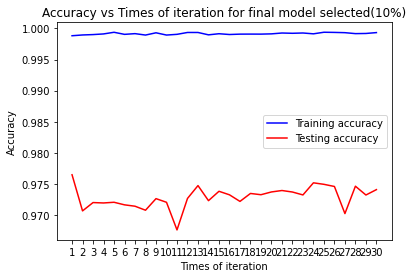

In [ ]:
import matplotlib.pyplot as plt
  
# create data
x = accuracy_comparison.iloc[:, 0]
y = accuracy_comparison.iloc[:, 1]
z = accuracy_comparison.iloc[:, 2]
  
# plot lines
plt.plot(x, y, label = "Training accuracy", color = 'b')
plt.plot(x, z, label = "Testing accuracy", color = 'r')
plt.xticks(x,x)
plt.title("Accuracy vs Times of iteration for final model selected(10%)")
plt.xlabel("Times of iteration")
plt.ylabel("Accuracy")
plt.savefig("Final Model Accuracy.jpeg")
plt.legend()
plt.show()


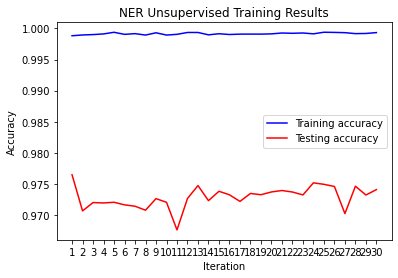

In [ ]:
import matplotlib.pyplot as plt
  
# create data
x = accuracy_comparison.iloc[:, 0]
y = accuracy_comparison.iloc[:, 1]
z = accuracy_comparison.iloc[:, 2]
  
# plot lines
plt.plot(x, y, label = "Training accuracy", color = 'b')
plt.plot(x, z, label = "Testing accuracy", color = 'r')
plt.xticks(x,x)
plt.title("NER Unsupervised Training Results")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.savefig("Final Model Accuracy.jpeg")
plt.legend()
plt.show()

#### Classification report

In [ ]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            #loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
            output = model(input_ids=ids, attention_mask=mask, labels=labels)

            eval_loss += output[0].item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = output[1].view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [ ]:
pretrained_model_path = "unsupervised_selftraining_BERTweet_final_iteration_23/model"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_path, add_prefix_space=True)
model = AutoModelForTokenClassification.from_pretrained(pretrained_model_path)
model.to(device)
params = {'batch_size': 1, 'shuffle': False, 'num_workers': 0}
testing_set = dataset(df_test, tokenizer, MAX_LEN)
testing_loader = DataLoader(testing_set, **params)
labels, predictions = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.3873063027858734
Validation loss per 100 evaluation steps: 0.1995727115537679
Validation loss per 100 evaluation steps: 0.24488842500784413
Validation loss per 100 evaluation steps: 0.24623549340932727
Validation loss per 100 evaluation steps: 0.24805629769220638
Validation loss per 100 evaluation steps: 0.2333371137240215
Validation loss per 100 evaluation steps: 0.2339242189080826
Validation Loss: 0.23858797138666218
Validation Accuracy: 0.9751886647268476


In [ ]:
print(classification_report(labels, predictions))

               precision    recall  f1-score   support

    B-company       0.79      0.60      0.68        43
   B-facility       0.61      0.61      0.61        28
    B-geo-loc       0.83      0.79      0.81        73
      B-movie       0.25      0.25      0.25         4
B-musicartist       0.47      0.50      0.49        18
      B-other       0.62      0.51      0.56        70
     B-person       0.89      0.85      0.87       133
    B-product       0.77      0.33      0.47        30
 B-sportsteam       0.70      0.64      0.67        11
     B-tvshow       1.00      0.31      0.47        13
    I-company       1.00      0.14      0.25         7
   I-facility       0.61      0.57      0.59        35
    I-geo-loc       0.71      0.62      0.67         8
      I-movie       0.33      0.22      0.27         9
I-musicartist       0.55      0.58      0.56        19
      I-other       0.73      0.53      0.61        99
     I-person       0.92      0.86      0.89        57
    I-pro

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy as np

def classification_report_to_df(report):
    report_data = report.splitlines()
    report_data = [report.split() for report in report_data]
    report = []
    for line in report_data[2:-4]:
      row = {}
      row['class'] = line[0]
      row['precision'] = float(line[1])
      row['recall'] = float(line[2])
      row['f1_score'] = float(line[3])   
      report.append(row)
    
    report.append({'class': report_data[-2][0] + " " + report_data[-2][1], 
                   'precision': float(report_data[-2][2]), 
                   'recall': float(report_data[-2][3]),
                   'f1_score': float(report_data[-2][4])})

    report.append({'class': report_data[-1][0] + " " + report_data[-2][1],  
                   'precision': float(report_data[-1][2]), 
                   'recall': float(report_data[-1][3]),
                   'f1_score': float(report_data[-1][4])})
    
    dataframe = pd.DataFrame.from_dict(report)
    dataframe = dataframe.set_index('class', drop = True)
    return dataframe

Text(0.5, 1.0, "Final NER model result for Ritter's dataset")

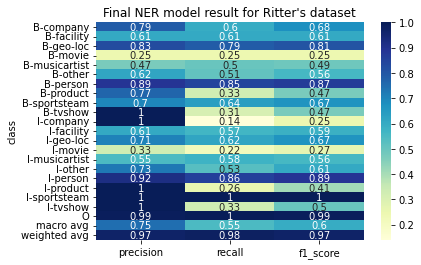

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = plt.axes()
sns.heatmap(classification_report_to_df(classification_report(labels, predictions)), ax = ax, annot = True, cmap="YlGnBu",  xticklabels=True, yticklabels=True)
ax.set_title('Final NER model result for Ritter\'s dataset')

### Save the model for further use

In [ ]:
import os

directory = "./final_model"

if not os.path.exists(directory):
    os.makedirs(directory)

# save vocabulary of the tokenizer
tokenizer.save_vocabulary(directory)
# save the model weights and its configuration file
model.save_pretrained(directory)
print('Final model saved')

Final model saved
